In [141]:
#Stars and stuff
from astroquery.gaia import Gaia
from astropy.io.votable import parse, parse_single_table
from astropy.timeseries import LombScargle

#Math
import numpy as np
from scipy.linalg import lstsq

#Matplotlib
import matplotlib.pyplot as plt

#Caching
from joblib import Memory

#File manipulation
from urllib.request import urlopen
import io
from glob import glob
import os

In [150]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a-b)))

In [125]:
def get_Gband(data,index=None,source_id=None):
    assert index!=None or source_id!=None, "Must pass in either index or source_id"
    if index!=None:
        if source_id!=None:
            print(f"Using index: {index} instead of source_id: {source_id}")
        selected_row=data[index]
        source_id=selected_row['source_id']
        print(f"Analyzing star with source_id: {source_id}")
    lc_f = f"lightcurve_files/{source_id}.xml"
    if os.path.exists(lc_f):
        votable = parse_single_table(lc_f)
    else:
        url = selected_row['epoch_photometry_url']
        votable = parse_single_table(url)
        
    Gband = votable.array[votable.array['band'] == 'G']
    return Gband

In [126]:
def plot_magnitude(Gband):
    time = Gband['time']
    mag = Gband['mag']
    mag_uncertainty = 1.09/Gband['flux_over_error']
    
    plt.figure(figsize=(8,5))
    plt.title("Magnitude w/ Magnitude Uncertainty")
    plt.fill_between(time, mag+mag_uncertainty/2,mag-mag_uncertainty/2, color='blue', alpha=0.5)
    plt.xlabel("Time")
    plt.ylabel("Magnitude")
    print(f"Estimated mean: {np.log(np.average(np.exp(mag)))}")

In [127]:
def estimate_period(Gband, p=False):
    mag = Gband['mag']
    flux = Gband['flux']
    time = Gband['time']
    flux_err = Gband['flux_error']
        
    freq, power = LombScargle(time, flux, flux_err).autopower(maximum_frequency=2.465,
                                                             minimum_frequency=1.044,
                                                             nyquist_factor=1)
    period = 1/freq[np.argmax(power)]
      
    phase = time % period
    if p:
        plt.figure(figsize=(8,5))
        plt.plot(freq, power, '-k')
        plt.xlabel("Frequency")
        plt.ylabel("Spectral Power")
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))
        
        ax1.scatter(phase, flux)
        ax1.set(xlabel="Phase", ylabel="Flux")
        
        ax2.scatter(phase, mag)
        ax2.set(xlabel="Magnitude", ylabel="Flux")
        
        plt.show()
        
        print(f"Estimated period: 1/{freq[np.argmax(power)]:.5f} = {period:.5f}")
#         print(f"Period as reported by vari_rrlyrae: {recorded_period:.5f}")
#         print(f"RMSE: {np.sqrt(np.mean(np.square(period - recorded_period)))}")
        
    return period

In [128]:
def get_gaia_query_rrlyrae(num_stars = 100, num_clean_epochs = 40, conds=None, verbose=False):
    add = ""
    if conds is not None:
        add = f"AND {conds}"
    query = f'''
        SELECT TOP {num_stars} *
        FROM gaiadr2.gaia_source as gaia
        JOIN gaiadr2.vari_rrlyrae using (source_id)
        WHERE
            num_clean_epochs_g > {num_clean_epochs}
            AND pf IS NOT NULL
    ''' + add
    if verbose:
        print(query)
    job = Gaia.launch_job_async(query)
    return job.get_results()

In [190]:
def setup_fit(Gband, k):
    period = estimate_period(Gband)
    w = 2*np.pi/period
    flux,time = Gband['flux'],Gband['time']
    num_samps = 2*k+1
    assert num_samps < len(flux), f"Number of samples drawn ({num_samps}) must be less than the length of the flux array ({len(flux)})"
    samp_mask = np.sort(np.random.choice(len(flux), num_samps, replace=False))
    print(samp_mask)
    flux_samp = flux[samp_mask]
    time_samp = time[samp_mask]
    X = np.zeros((num_samps, num_samps))
    k_s = np.arange(1,k+1)
    tk_tiling = np.outer(time_samp, k_s)
    X[:,0] = np.ones(num_samps)
    X[:,1:k+1] = np.sin(tk_tiling)
    X[:,k+1:] = np.cos(tk_tiling)
    return X, flux_samp, time_samp, samp_mask

In [130]:
location = "./cachedir"
memory = Memory(location, verbose=0)
get_gaia_query_rrlyrae_cached = memory.cache(get_gaia_query_rrlyrae)

In [131]:
rrlyrae_100 = get_gaia_query_rrlyrae_cached(num_stars = 100, num_clean_epochs=40)
rrlyrae_100[:10]

solution_id,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,solution_id_2,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification,source_id
,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,,
int64,object,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object,int64
1635721458409799680,Gaia DR2 5866125710834119808,841033097,2015.5,212.93756378519396,1.8166386676862833,-62.00766431869603,1.9494294407044717,--,--,--,--,--,--,--,0.31046233,--,--,--,--,--,--,--,--,--,259,0,231,28,67.230064,6779.6177,16.72209529440

In [162]:
selected_Gband = get_Gband(rrlyrae_100, 9)

Analyzing star with source_id: 5821156028840408576


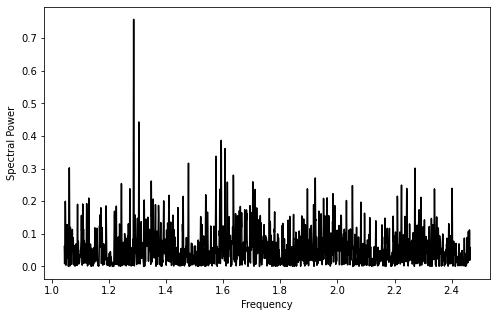

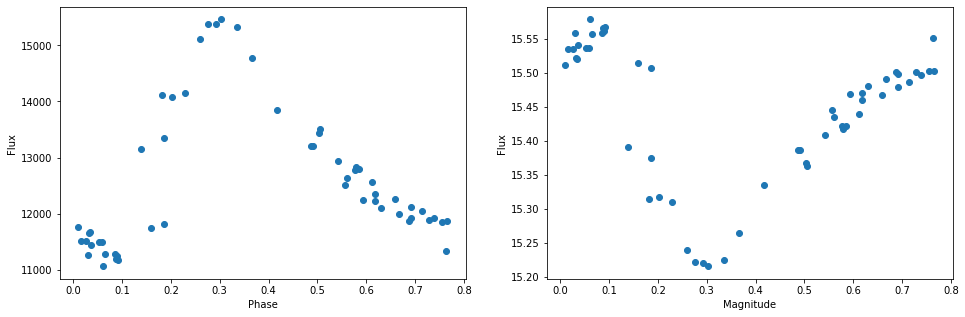

Estimated period: 1/1.28663 = 0.77723
Period as reported by vari_rrlyrae: 0.77735
RMSE: 0.0001221022415976991


In [163]:
period = estimate_period(selected_Gband, p=True)
recorded_period = rrlyrae_100['pf'][9]
print(f"Period as reported by vari_rrlyrae: {recorded_period:.5f}")
print(f"RMSE: {np.sqrt(np.mean(np.square(period - recorded_period)))}")

Estimated mean: 15.450506260632958


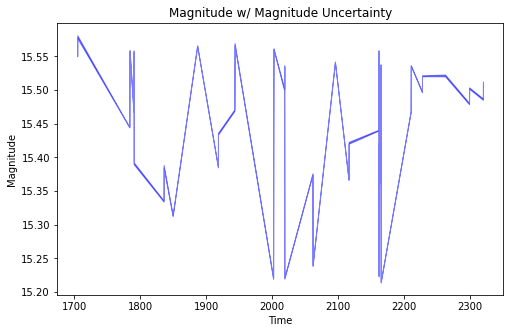

In [164]:
plot_magnitude(selected_Gband)

In [175]:
setup_Q5(selected_Gband,2,period)

[[ 1.          0.20541033 -0.4020603  -0.97867594  0.91561319]
 [ 1.          0.39997321  0.73317235  0.91652683  0.68004287]
 [ 1.          0.34074745  0.64071075  0.94015487  0.76778235]
 [ 1.         -0.96936729 -0.47618358  0.24561566 -0.87934589]
 [ 1.          0.04387652 -0.08766854 -0.99903696  0.9961497 ]]


In [198]:
X, f, t, _ = setup_fit(selected_Gband, 25)
b = lstsq(X, f.data)[0]
print(rmse(np.dot(X, b), f))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 49
 51 53 54]
1.2277812233759968


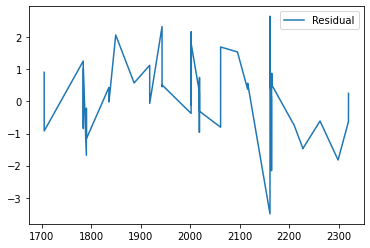

In [201]:
plt.figure()
# plt.plot(t, f, label="Truth")
# plt.plot(t, X.dot(b), label="Predicted")
plt.plot(t, f-X.dot(b), label="Residual")
plt.legend()